<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/main/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [2]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub
!pip install --upgrade tensorflow
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=c0f5b937793a735a1bcff73e247a9e26f4021c1eb38327c96351452e3151673c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully unin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


## Libraries

In [1]:
# LIBRARIES

import os
import pandas as pd
import numpy as np
import json
import shutil
import random

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import History

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, pipeline
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge', seed=42) #It is not deterministic

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-1-fedf9226775a>:37: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge', seed=42) #It is not deterministic
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

## Logins, Paths and Auxiliar Functions

In [2]:
# Connect w/ HuggingFace HUB
from huggingface_hub import notebook_login
notebook_login()

In [2]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# PATHS
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/"

documents = os.listdir(BASE_PATH)

Mounted at /content/drive/


In [3]:
# AUXILIAR FUNCTIONS

# Function to convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell



# Function to join all the sentences of input document
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data




# Define the metric to use (ROUGE Scores)
def metric_fn(eval_predictions):
  predictions, labels = eval_predictions

  for prediction in predictions:
      prediction[prediction < 0] = tokenizer.pad_token_id  # Replace masked prediction tokens

  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )

  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

## Preprocess Data

In [4]:
data = pd.read_csv(BASE_PATH+'Data/Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.head(5)

,source,paper_id,target,title,number_words_target,extractive_summary
0,Due to the success of deep learning to solving...,SysEexbRb,We provide necessary and sufficient analytical...,NaN,38,We are interested in the square loss function ...
1,Generative Adversarial Networks (GANs) have ac...,ryj38zWRb,Are GANs successful because of adversarial tra...,NaN,36,"On the one hand, a generator plays to transfor..."
2,Dialogue systems require a great deal of diffe...,BJepraEFPr,"In this paper, we propose to learn a dialogue ...",NaN,30,"However, several problems arise with this impl..."
3,Backdoor attacks aim to manipulate a subset of...,rkgyS0VFvr,We proposed a novel distributed backdoor attac...,NaN,35,"Compared to standard centralized backdoors, we..."
4,The integration of a Knowledge Base (KB) into...,SJl7tREFvr,Conventional memory networks generate many red...,NaN,32,Given the large amount of dialogue data record...


In [5]:
# Count number of words of source and target
def count_words(data, column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words(data, 'target')
data['number_words_source'] = count_words(data, 'source')
data['number_words_extractive'] = count_words(data, 'extractive_summary')

In [6]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    1312.000000
mean       58.935213
std        20.402388
min        30.000000
25%        41.000000
50%        58.000000
75%        73.000000
max       149.000000
Name: number_words_target, dtype: float64
count     1312.000000
mean      5177.437500
std       2107.094236
min        126.000000
25%       4069.750000
50%       5001.500000
75%       6187.750000
max      24589.000000
Name: number_words_source, dtype: float64
count    1312.000000
mean      621.176067
std       143.951058
min       126.000000
25%       534.000000
50%       611.000000
75%       693.000000
max      1199.000000
Name: number_words_extractive, dtype: float64


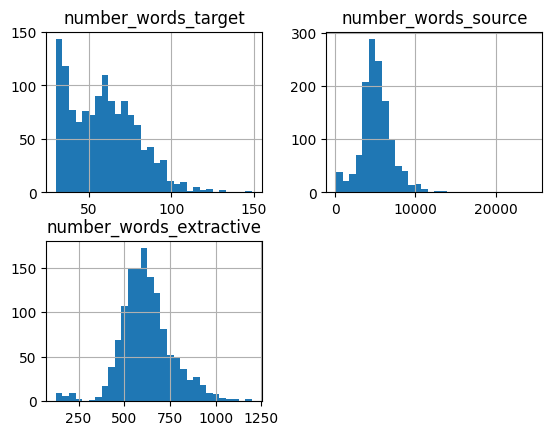

In [7]:
# Histogramas
data.hist(bins=30)
plt.show()

In [8]:
data = data[data['number_words_target']>=40].reset_index(drop=True)
data['number_words_target'].describe()

count    1012.000000
mean       66.381423
std        17.169049
min        40.000000
25%        54.000000
50%        64.000000
75%        77.000000
max       149.000000
Name: number_words_target, dtype: float64

In [9]:
synonyms_paper = ['paper', 'study', 'work', 'article']
articles = ['The', 'the', 'This', 'this', 'A', 'a', 'An', 'an']

def substitution(text, syn, articles):
  list_words = text.split()
  new_list_words = []
  for index, word in enumerate(list_words):
    if word in articles and list_words[index+1] in syn:
      new_list_words.append(word)
      new_list_words.append(random.choice(syn))
    elif word in syn and list_words[index-1] in articles:
      continue
    else:
      new_list_words.append(word)
  return ' '.join(new_list_words)

data['extractive_summary'] = data['extractive_summary'].apply(lambda x : substitution(x, synonyms_paper, articles))
data['target'] = data['target'].apply(lambda x : substitution(x, synonyms_paper, articles))

## BART



#### Prepare Data for Tokenization

In [10]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        random_state=42)

In [11]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(647, 8) (162, 8) (809, 8) (203, 8)


In [12]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

In [13]:
# # Tokenize data
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', errors='ignore')

# # Function in order to tokenize source and target
# max_input_length = 1024

# def tokenize_function(data):
#   model_inputs = tokenizer(text=data['extractive_summary'], text_target=data['target'], max_length=max_input_length, truncation=True)
#   return model_inputs

# tokenized_data = raw_data.map(tokenize_function, batched=True)

In [14]:
# Tokenize data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', errors='ignore')

# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

tokenized_data = raw_data.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/647 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/162 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

### Prepare Data for Training

In [15]:
# Load BART Base-Model
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

model.generation_config.max_length = 150
model.generation_config.min_length = 60
model.generation_config.length_penalty = 2.0
model.generation_config.num_beams = 4

model.generation_config.do_sample = False
model.generation_config.temperature = 1
model.generation_config.begin_suppress_tokens  = [tokenizer.convert_tokens_to_ids('We')]
model.generation_config.suppress_tokens = [
    # tokenizer.convert_tokens_to_ids('Ġpaper'),
                                           tokenizer.convert_tokens_to_ids('ĠPro'),
                                          # tokenizer.convert_tokens_to_ids('Ġauthors'),
                                           tokenizer.convert_tokens_to_ids('ĠIntrodu')]
                                          #  tokenizer.convert_tokens_to_ids('Ġwork'),
                                          #  tokenizer.convert_tokens_to_ids('Ġmethod')]

model.generation_config.num_beam_groups = 4
model.generation_config.diversity_penalty = 0.7

model.generation_config.no_repeat_ngram_size = 3

model.generation_config.repetition_penalty = 1.3

# model.generation_config.renormalize_logits = True

model.config.attention_dropout = 0.1

use_XLA = False
if use_XLA:
  model.generation_config.no_repeat_ngram_size = 0 # In order to use XLA Generation

name_model = 'greedy-norep-v5/'

print(model.generation_config)


batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.7,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 60,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.3,
  "suppress_tokens": [
    1698,
    32687
  ]
}



In [16]:
model.config

BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 1024,
  "model_ty

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

if use_XLA:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)
else:
  generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", padding=True)

In [18]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [19]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(100):  # Take the first batch for inspection
    print(batch[0])

{'input_ids': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[    0,   170,   311, ...,     1,     1,     1],
       [    0, 20930,    15, ...,     1,     1,     1],
       [    0, 35703,     6, ...,     1,     1,     1],
       ...,
       [    0,  3376,  5969, ...,     1,     1,     1],
       [    0, 44891,     7, ...,     1,     1,     1],
       [    0,     6,   992, ...,    81, 14307,     2]])>, 'attention_mask': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])>, 'decoder_input_ids': <tf.Tensor: shape=(8, 182), dtype=int64, numpy=
array([[    2,     0,   250, ...,     1,     1,     1],
       [    2,     0,  1121, ...,     1,     1,     1],
       [    2,     0,   250, ...,     1,     1,     1],
       ...,
       [    2,     0,   170, ...,     1,     1,     1],
       

In [20]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [21]:
768*1024

786432

In [22]:
save_path = BASE_PATH + '/Results/TLDR/BART/model_save/' + name_model

In [23]:
#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True,
    use_xla_generation=use_XLA
)

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./model_save",
#     tokenizer=tokenizer,
#     hub_model_id="iguerrasevillano/BART-summ-v1",
#     save_strategy='epoch',
#     checkpoint=True
# )


checkpoint_callback = ModelCheckpoint(
    filepath=save_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
resume = False
epochs = 10

callbacks = [metric_callback,
            #  push_to_hub_callback,
             stop_early,
             checkpoint_callback]

# Train
print('[INFO: fine-tuning model...]')
H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

# Save the model and tokenizer to a directory
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

[INFO: fine-tuning model...]
Epoch 1/10
81/81 [==============================] - 3539s 44s/step - loss: 3.8401 - val_loss: 3.3434 - rouge1: 38.3768 - rouge2: 10.4465 - rougeL: 22.5889 - rougeLsum: 32.1108 - gen_len: 85.7037
Epoch 2/10
52/81 [==================>...........] - ETA: 6:13 - loss: 3.5176

In [ ]:
with open(save_path + 'training_history.json', 'w') as file:
    json.dump(H.history, file)

In [ ]:
# List all files in the source folder
weights_last_epoch = 'tf_model.h5'

source_file_path = os.path.join(save_path, weights_last_epoch)
os.makedirs(save_path + 'last_epoch/')
destination_file_path = os.path.join(save_path, 'last_epoch/', weights_last_epoch)
shutil.move(source_file_path, destination_file_path)

print(f"File {weights_last_epoch} moved from {source_file_path} to {destination_file_path}")

In [ ]:
# Change name
original_path = save_path + '/weights.h5'
new_name = 'tf_model.h5'

# Create the new file path
new_path = os.path.join(os.path.dirname(original_path), new_name)

# Rename the file
os.rename(original_path, new_path)

print(f"File weights.h5 renamed as {new_name}")

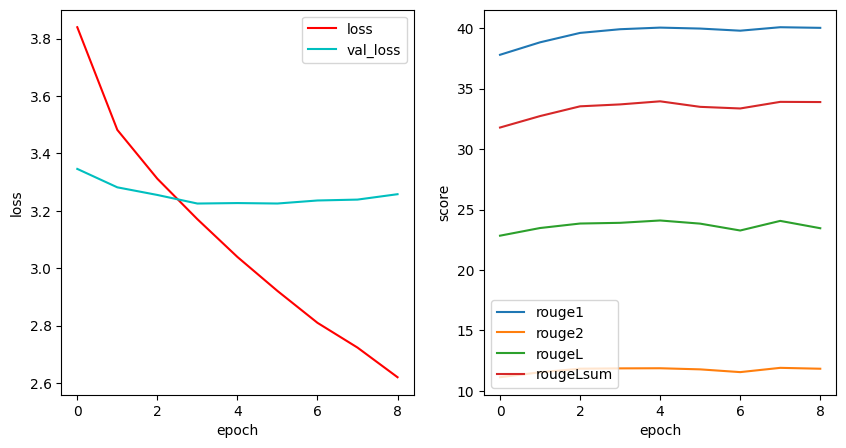

In [37]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], 'r', label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], 'c', label="val_loss")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc="upper right")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeL"], label="rougeL")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeLsum"], label="rougeLsum")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('score')
    ax[1].legend()

plot_graphics(H)
plt.savefig(save_path + '/history.png')

### Evaluation

In [15]:
name_models = {'sampling-norep-v0' : 'sampling-norep-v0/',
              #  'sampling-norep-v1' : 'sampling-norep-v1/',
              #  'greedy-norep-v0' : 'greedy-norep-v0/',
              #  'greedy-norep-v1' : 'greedy-norep-v1/',
              #  'greedy-norep-v2' : 'greedy-norep-v2/',
              #  'greedy-norep-v3' : 'greedy-norep-v3/',
               'greedy-norep-v4' : 'greedy-norep-v4'}

save_paths = {}
models = {}
# tokenizers = {}

for name in name_models:
  save_paths[name] = BASE_PATH + '/Results/TLDR/BART/model_save/' + name_models[name]

  models[name] = TFAutoModelForSeq2SeqLM.from_pretrained(save_paths[name])
  # tokenizers[name] = BartTokenizer.from_pretrained(save_path[name])
  print(models[name].generation_config)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/sampling-norep-v0/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2,
  "max_length": 150,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.2,
  "temperature": 0.5
}



All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/VIU/TFM/Desarrollo//Results/TLDR/BART/model_save/greedy-norep-v4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.5,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 80,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ]
}



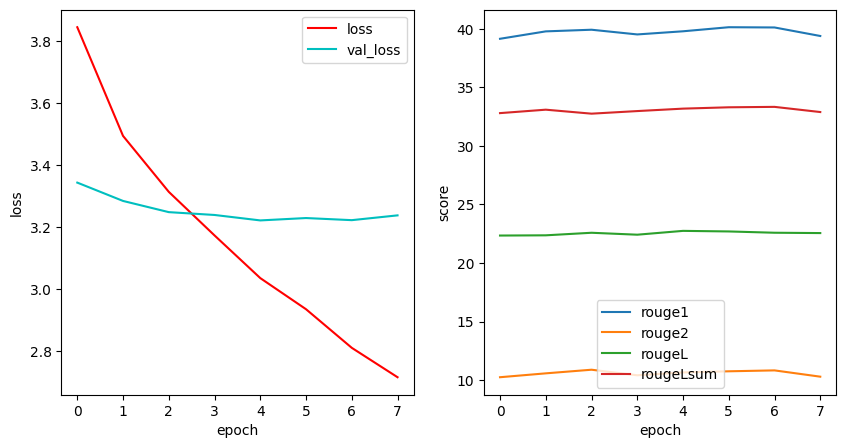

In [16]:
name = 'greedy-norep-v4'
save_path = save_paths[name]

with open(save_path + '/training_history.json', 'r') as file:
    loaded_history = json.load(file)

H = History()
H.history = loaded_history


def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], 'r', label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], 'c', label="val_loss")
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc="upper right")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeL"], label="rougeL")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rougeLsum"], label="rougeLsum")
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('score')
    ax[1].legend()

plot_graphics(H)
plt.savefig(save_path + '/figure.png')

In [17]:
name = 'greedy-norep-v4'

In [18]:
models[name].generation_config

GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.5,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 80,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ]
}

In [77]:
ids = models[name].generate(tokenized_data['test']['input_ids'][5:7],
                                        generation_config=models[name].generation_config,
                                        seed=42)

In [44]:
ids = model.generate(tokenized_data['test']['input_ids'][0:4],
                                        generation_config=model.generation_config,
                                        seed=42)

In [45]:
tokenizer.batch_decode(ids, skip_special_tokens=True)

['The authors propose a variational Dirichlet framework for deep neural network classification and propose a higher-order uncertainty measure. This work proposes a new approach to the problem of distinguishing between out-of-distribution and in-domain examples. This paper proposes a novel variational method for image classification based on the label-level uncertainty of the data.',
 'An unsupervised method for analyzing the contribution of individual neurons to NMT models. This paper proposes a novel approach to interpret language using neural networks, and proposes a new method to analyze the contributions of neural networks to language models. The authors propose a novel method for interpreting language representations by studying the activation of neurons in a neural network.',
 'Deep diagonal-circulant ReLU networks of bounded width and small depth can approximate a deep ReLU network in which the dense matrices are of low rank. This paper proposes to replace the weight matrix of a

In [41]:
tokenizer.batch_decode(ids, skip_special_tokens=True)

['The authors propose a variational Dirichlet framework for deep neural network classification. This work proposes a new uncertainty metric that can be used to detect out-of-distribution examples in order to improve the accuracy of deep neural networks. The study proposes a novel uncertainty metric for image classification based on the label-level entropy, which is more accurate than other uncertainty measures.',
 'An unsupervised method for analyzing the contribution of individual neurons to NMT models. This paper proposes a novel approach to interpret language using neural networks, and proposes a new method that uses multiple neurons in each model. The authors propose a novel method for studying the contributions of neural networks to language models, which is based on an analysis of the activation of different neurons in a neural network.',
 'Deep diagonal-circulant ReLU networks of bounded width and small depth can approximate a deep ReLU network in which the dense matrices are of

In [42]:
tokenized_data['test']['target'][0:4]

['A new framework based variational inference for out-of-distribution detection Describes a probabilistic approach to quantifying uncertainty in DNN classification tasks that outperforms other SOTA methods in the task of out-of-distribution detection. A new framework for out-of-distribution detection, based on variaitonal inference and a prior Dirichlet distribution, that reports state of the art results on several datasets. An out-of distribution detection via a new method to approximate the confidence distribution of classification probability using variational inference of Dirichlet distribution.',
 'Unsupervised methods for finding, analyzing, and controlling important neurons in NMT This work presents unsupervised approaches to discovering important neurons in neural machine translation systems and analyzes linguistic properties controlled by those neurons. Unsupervised methods for ranking neurons in machine translation where important neurons are thus identified and used to contr

In [43]:
model = models[name]
model.generation_config.max_length = 150
model.generation_config.min_length = 60
model.generation_config.length_penalty = 2.0
model.generation_config.num_beams = 4

model.generation_config.do_sample = False
model.generation_config.temperature = 1
model.generation_config.begin_suppress_tokens  = [tokenizer.convert_tokens_to_ids('We')]
model.generation_config.suppress_tokens = [
    # tokenizer.convert_tokens_to_ids('Ġpaper'),
                                           tokenizer.convert_tokens_to_ids('ĠPro'),
                                          # tokenizer.convert_tokens_to_ids('Ġauthors'),
                                           tokenizer.convert_tokens_to_ids('ĠIntrodu')]
                                          #  tokenizer.convert_tokens_to_ids('Ġwork'),
                                          #  tokenizer.convert_tokens_to_ids('Ġmethod')]

model.generation_config.num_beam_groups = 4
model.generation_config.diversity_penalty = 0.7

model.generation_config.no_repeat_ngram_size = 3

model.generation_config.repetition_penalty = 1.3

print(model.generation_config)

GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.7,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 60,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.3,
  "suppress_tokens": [
    1698,
    32687
  ]
}



In [36]:
name

'greedy-norep-v4'

In [19]:
generated_summaries = []
rouge_scores = []
accumulated_metrics = {}

n = len(tokenized_data['test']['input_ids'])
batch_size = 2 # Must be greater than 1

# Last batch is dropped (just one sample if batch_size=2) to average ROUGE scores properly
for i in range(0, n-1, batch_size):
  if i % 10 == 0:
    print(f'[INFO]: {i}/{n-1}')


  generated_ids = models[name].generate(tokenized_data['test']['input_ids'][i:i+batch_size],
                                        generation_config=models[name].generation_config,
                                        seed=42)
  reference_labels = np.array(tokenized_data['test']['labels'][i:i+batch_size])

  predicted_labels = np.array(generated_ids)

  current_metrics = metric_fn((predicted_labels, reference_labels))
  accumulated_metrics = {k : current_metrics.get(k, 0) + accumulated_metrics.get(k, 0) for k in current_metrics.keys()}

  # Predicted summaries, keep the rouge scores
  generated_summaries.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
  rouge_scores.append(current_metrics)

# Undo nested list
generated_summaries = [summary for summaries in generated_summaries for summary in summaries]
average_rouge_scores = {k : accumulated_metrics.get(k, 0)/len(range(0, n-1, batch_size)) for k in accumulated_metrics.keys()}

[INFO]: 0/202
[INFO]: 10/202
[INFO]: 20/202
[INFO]: 30/202
[INFO]: 40/202
[INFO]: 50/202
[INFO]: 60/202
[INFO]: 70/202
[INFO]: 80/202
[INFO]: 90/202
[INFO]: 100/202
[INFO]: 110/202
[INFO]: 120/202
[INFO]: 130/202
[INFO]: 140/202
[INFO]: 150/202
[INFO]: 160/202
[INFO]: 170/202
[INFO]: 180/202
[INFO]: 190/202
[INFO]: 200/202


In [30]:
model = models[name]
model.generation_config

GenerationConfig {
  "begin_suppress_tokens": [
    170
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "diversity_penalty": 0.5,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 150,
  "min_length": 80,
  "no_repeat_ngram_size": 3,
  "num_beam_groups": 4,
  "num_beams": 4,
  "pad_token_id": 1,
  "repetition_penalty": 1.8,
  "suppress_tokens": [
    1698,
    32687
  ]
}

In [21]:
updated_data_test = data_test[:-1].reset_index(drop=True)
updated_data_test['abstractive_summary'] = pd.Series(generated_summaries)

updated_data_test['number_words_abstractive'] = count_words(updated_data_test, 'abstractive_summary')

updated_data_test['length_difference'] = updated_data_test['number_words_target'] - updated_data_test['number_words_abstractive']

updated_data_test.to_csv(save_path + '/updated_data_test.csv', index=False)

summaries = updated_data_test[['target', 'abstractive_summary']]
summaries.to_csv(save_path + '/summaries.csv', index=False)

with open(save_path + '/average_rouge_scores.json', 'w') as json_scores:
    json.dump(average_rouge_scores, json_scores, indent=4)

In [29]:
updated_data_test['length_difference'].describe()

count    202.000000
mean      -7.420792
std       18.294337
min      -49.000000
25%      -21.000000
50%       -8.000000
75%        4.000000
max       58.000000
Name: length_difference, dtype: float64

In [ ]:
i = 6
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:OE teaches anomaly detectors to learn heuristics for detecting unseen anomalies; experiments are in classification, density estimation, and calibration in NLP and vision settings; we do not tune on test distribution samples, unlike previous work
FINE TUNED MODEL:Outlier Exposure improves the calibration of neural network classifiers in the realistic setting where a fraction of the data is OOD. We show that Outlier Exposure can improve calibration performance in this realistic setting.
PRETRAINED MODEL:However, when there is a distribution mismatch, deep neural network classifiers tend to give


In [84]:
m = 28
print(summaries.iloc[m, 0])
print(summaries.iloc[m, 1])

We train with state aligned vector rewards an agent predicting state changes from action distributions, using a new reinforcement learning technique inspired by quantile regression. Presents algorithm that aims to speed up reinforcement learning in situations where the reward is aligned with the state space.  This paper addresses RL in the continuous action space, using a re-parametrised policy and a novel vector-based training objective. This work proposes to mix distributional RL with a net in charge of modeling the evolution of the world in terms of quantiles, claiming improvements in sample efficiency.
We extend the reinforcement learning paradigm to a d-dimensional hypercube and show that quantile regression is capable of training orders of magnitudes faster in high dimensional metric spaces. This paper proposes a method to train a deep neural network to approximate the quantile function of the optimal action distribution. The authors propose a new reinforcement learning algorithm

In [27]:
summaries['target'][20]

'We present NormCo, a deep coherence model which considers the semantics of an entity mention, as well as the topical coherence of the mentions within a single document to perform disease entity normalization. Uses a GRU autoencoder to represent the "context" (related enitities of a given disease within the span of a sentence), solving the BioNLP task with significant improvements over the best-known methods.'

In [28]:
summaries['abstractive_summary'][20]

'Improving disease normalization with two sub-models. The authors propose a new approach to the problem of disease normalizing that combines semantic features and topical coherence. This paper proposes a novel method for improving the accuracy of disease normalized methods by combining semantic features with non-normalization information. This work proposes a new model for disease normalized methods, which combines lexical features and contextual coherence to improve the accuracy and coherence of the existing models.'